<a href="https://colab.research.google.com/github/Icaro92/laranjas_linear_regression/blob/main/projeto_laranja_regress%C3%A3o_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão do Valor da Produção de Laranjas com Regressão Linear


---


Este projeto tem como objetivo prever o valor da produção de laranjas (em R$) utilizando dados da Pesquisa Produção Agrícola Municipal (PAM), realizada anualmente pelo Instituto Brasileiro de Geografia e Estatística (IBGE). Com base nesses dados, buscamos estimar a produção futura de laranjas e seu impacto econômico.

A PAM investiga, a cada ano, os principais produtos das lavouras temporárias e permanentes no Brasil. Esses produtos têm grande relevância tanto na economia nacional, devido ao seu peso nas exportações, quanto na vida cotidiana dos brasileiros, uma vez que muitos compõem a cesta básica.

A motivação principal para este estudo é o meu interesse pessoal pela produção de laranjas e a importância dessa cultura no Brasil.

**Base de Dados**


* Dados da produção de laranjas: [Base de Dados - PAM (IBGE)](https://basedosdados.org/dataset/fc403b40-a7e1-40e7-9efe-910847b45a69?table=bd9b2960-361f-4465-be23-baaadaaf266d)

* Dados dos municípios e estados (Censo 2022 - IBGE): [Base de Dados - Censo 2022 (IBGE)](https://basedosdados.org/dataset/08a1546e-251f-4546-9fe0-b1e6ab2b203d?table=ebd0f0fd-73f1-4295-848a-52666ad31757)



# Importação e Unificação das bases

* Consultas SQL para a PAM e o Censo 2022:

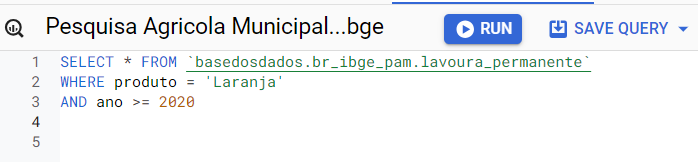



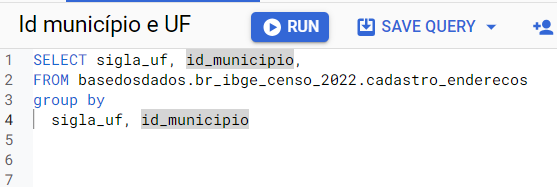


In [ ]:
#Bibliotecas padrão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# regressão:
from sklearn.linear_model import LinearRegression # regressão linear
from sklearn.linear_model import Lasso # regressão Lasso
from sklearn.model_selection import train_test_split  # divisão treino teste
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error #validação do modelo (R², RMSE e MAE)
from sklearn.linear_model import Ridge

# pipeline:
from sklearn.pipeline import Pipeline # gerando pipeline
from sklearn.pipeline import make_pipeline # extraindo infos da pipeline
from sklearn.compose import ColumnTransformer # agrupação de métodos para pipeline

# processamento de variáveis numéricas:
from sklearn.preprocessing import RobustScaler # ajuste da escala das features
from sklearn.preprocessing import power_transform # normalizando target

# processamento de variáveis nominais:
!pip install category_encoders
from category_encoders import CountEncoder # transformação por frequencia

# testando multicolinearidade:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor # verificação de multicolinearidade

# testando normalidade (resíduos e variáveis):
import scipy.stats as stats
from scipy.stats import shapiro # teste de normalidade

# warnings:
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 7.1 MB/s eta 0:00:00


In [ ]:
df_laranja = pd.read_csv('database_laranja_ibge.csv') #importando tabela produção laranja
print(df_laranja.shape)
print(df_laranja.isnull().sum())

(16605, 9)
ano                             0
sigla_uf                        0
id_municipio                    0
produto                         0
area_destinada_colheita      9451
area_colhida                 9454
quantidade_produzida         9454
rendimento_medio_producao    9454
valor_producao               9454
dtype: int64


In [ ]:
df_estado = pd.read_csv('/content/estado_municipio_id.csv') #importando tabela de municípios por ID
print(df_estado.shape)
print(df_estado.isnull().sum())

(5569, 2)
sigla_uf        0
id_municipio    0
dtype: int64


In [ ]:
df = pd.merge(df_laranja, df_estado, on=['sigla_uf', 'id_municipio'], how='inner') #unindo os datasets
df.shape

(16602, 9)

# Análise e Tratamento da Base de Dados:

* Identifiquei que aproximadamente 80% da produção de laranjas no Brasil está concentrada em apenas 7 estados.
* Por isso, restringi o dataset para focar nesses estados, visando aumentar a precisão da modelagem.
* Realizei diversos tratamentos nos dados para preparar a base para o processo de modelagem preditiva.
* Também fiz levantamentos gerais sobre as principais características da base de dados após os tratamentos, garantindo sua adequação para o modelo.



In [ ]:
df.dropna(inplace=True) #removendo valores nulos
df.shape

(7148, 9)

In [ ]:
df.dtypes #os tipos de dados estão corretos com nossos objetivos

,0
ano,int64
sigla_uf,object
id_municipio,int64
produto,object
area_destinada_colheita,float64
area_colhida,float64
quantidade_produzida,float64
rendimento_medio_producao,float64
valor_producao,float64


In [ ]:
df['valor_producao'].describe() #variação da variável target está muito elevada, implica na necessidade moldar o dataset

,valor_producao
count,7148.000000
mean,5264.295048
std,24259.637462
min,1.000000
25%,47.000000
50%,184.000000
75%,941.250000
max,546700.000000


In [ ]:
# 80% da produção de laranja do Brasil está concentrada em 7 estados.
prod_df = df.groupby('sigla_uf')['valor_producao'].mean().reset_index().sort_values(by = 'valor_producao', ascending=False)
prod_df['percent'] = (prod_df['valor_producao'] / prod_df['valor_producao'].sum())*100
prod_df['cumsum'] = prod_df['percent'].cumsum()
prod_df.head(7)

,sigla_uf,valor_producao,percent,cumsum
24,SP,26737.660269,41.161846,41.161846
23,SE,10749.873239,16.549116,57.710962
17,RJ,3840.469136,5.912290,63.623252
7,GO,3189.431655,4.910037,68.533288
1,AL,2686.505435,4.135797,72.669085
16,PR,2602.150845,4.005935,76.675020
9,MG,2519.917625,3.879340,80.554360


<Figure size 640x480 with 0 Axes>

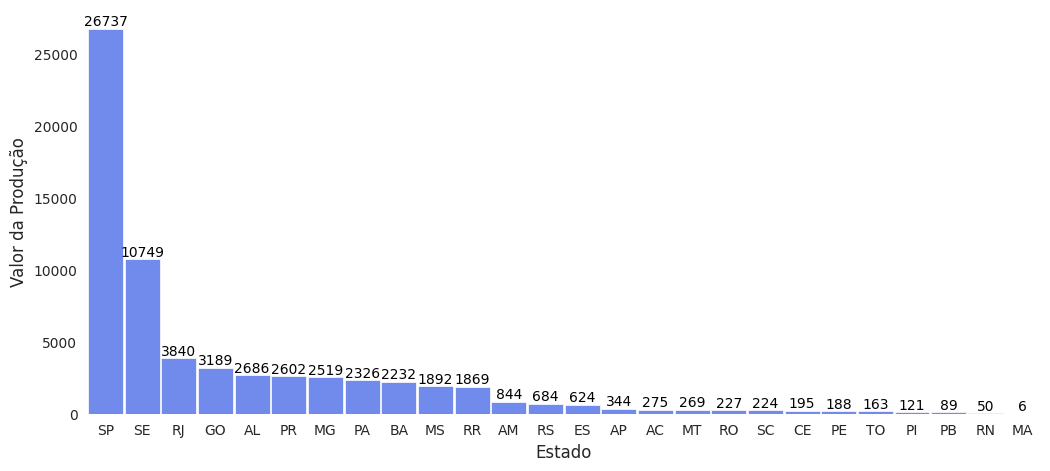

In [ ]:
#visualização gráfica
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
sns.despine(left=True, bottom=True)

plt.figure(figsize=(12.3, 5.25))
ax = sns.barplot(data=df.groupby('sigla_uf')['valor_producao']
            .mean().reset_index().
            sort_values(by = 'valor_producao', ascending=False),
            x='sigla_uf', y='valor_producao', color='#5B80FF', width=0.95)

sns.despine(left=True, bottom=True)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.ylabel('Valor da Produção')
plt.xlabel('Estado')
ax.yaxis.set_visible(True)
plt.show()



A maior parte da produção de laranja está concentrada nos estados de São Paulo (SP), Sergipe (SE), Rio de Janeiro (RJ), Goiás (GO), Alagoas (AL), Paraná (PR) e Minas Gerais (MG). Por isso, faz sentido restringir o modelo apenas a esses estados, garantindo que o foco permaneça nas regiões mais representativas para a análise da produção de laranja.

In [ ]:
df_estados = df[df['sigla_uf'].isin(['SP', 'SE', 'RJ', 'GO', 'AL', 'PR', 'MG'])] #mantém somente os estados de SE, SP, RJ, GO, AL, PR, MG
df_estados['valor_producao'].describe()

,valor_producao
count,3330.000000
mean,10361.698799
std,34309.333237
min,3.000000
25%,58.250000
50%,346.500000
75%,4871.000000
max,546700.000000


In [ ]:
df_estados.head()

,ano,sigla_uf,id_municipio,produto,area_destinada_colheita,area_colhida,quantidade_produzida,rendimento_medio_producao,valor_producao
97,2022,AL,2700409,Laranja,9.0,9.0,95.0,10556.0,160.0
98,2022,AL,2701100,Laranja,2500.0,2200.0,25443.0,11565.0,33504.0
99,2022,AL,2701308,Laranja,80.0,80.0,893.0,11163.0,1275.0
100,2022,AL,2701902,Laranja,450.0,450.0,5500.0,12222.0,9185.0
101,2022,AL,2702801,Laranja,70.0,70.0,810.0,11571.0,1150.0


In [ ]:
base = df_estados.copy() #salva o dataset original

In [ ]:
#preparação da base para aplicar o modelo:
base = base.drop(columns=['produto', 'id_municipio'])
base = pd.get_dummies(base, columns=['sigla_uf'], drop_first=False)
for col in base.columns: #transformar booleanos em inteiros faz com que o modelo utilize melhor as variáveis de estado
    if col.startswith('sigla_uf_'):
        base[col] = base[col].astype(int)

In [ ]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3330 entries, 97 to 16601
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ano                        3330 non-null   int64  
 1   area_destinada_colheita    3330 non-null   float64
 2   area_colhida               3330 non-null   float64
 3   quantidade_produzida       3330 non-null   float64
 4   rendimento_medio_producao  3330 non-null   float64
 5   valor_producao             3330 non-null   float64
 6   sigla_uf_AL                3330 non-null   int64  
 7   sigla_uf_GO                3330 non-null   int64  
 8   sigla_uf_MG                3330 non-null   int64  
 9   sigla_uf_PR                3330 non-null   int64  
 10  sigla_uf_RJ                3330 non-null   int64  
 11  sigla_uf_SE                3330 non-null   int64  
 12  sigla_uf_SP                3330 non-null   int64  
dtypes: float64(5), int64(8)
memory usage: 364.2 KB


In [ ]:
base.shape

(3330, 13)

In [ ]:
base.isnull().sum()

,0
ano,0
area_destinada_colheita,0
area_colhida,0
quantidade_produzida,0
rendimento_medio_producao,0
valor_producao,0
sigla_uf_AL,0
sigla_uf_GO,0
sigla_uf_MG,0
sigla_uf_PR,0


# Preparando os Dados e Treinando o Modelo

Encontrei alguns problemas nos gráficos abaixo:

* A presença de outliers com valores altamente discrepantes
* A distribuição assimétrica, com uma cauda à direita

Para resolver esses problemas, decidi:

* Aplicar o tratamento de outliers utilizando o método IQR (Interquartile Range)
* Utilizar a escala logarítmica na variável target para reduzir a assimetria e aproximar sua distribuição de uma normal

Quando a variável target tem uma distribuição mais próxima da normal, aumenta a probabilidade de que os resíduos também sigam essa distribuição, o que é consistente com a suposição da regressão linear. Verificarei isso mais adiante.

**Target**

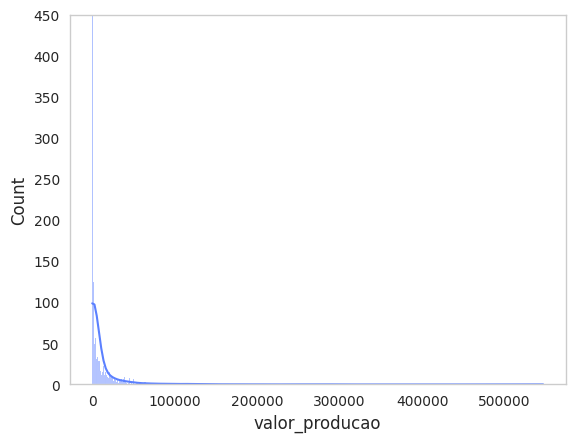

In [ ]:
#verificando a distribuição da variável target
sns.histplot(base['valor_producao'], kde=True, color='#5B80FF')
plt.ylim(0,450)
plt.show()


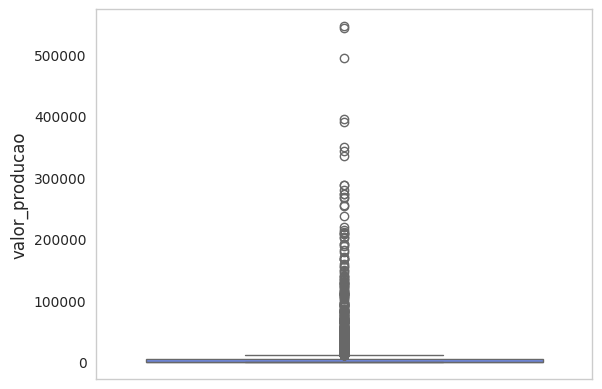

In [ ]:
sns.boxplot(base['valor_producao'], color='#5B80FF');

In [ ]:
base['valor_producao'].describe()

,valor_producao
count,3330.000000
mean,10361.698799
std,34309.333237
min,3.000000
25%,58.250000
50%,346.500000
75%,4871.000000
max,546700.000000


In [ ]:
# Tratando outliers através do IQR

#Calcula o primeiro e terceiro quadrante
Q1 = base['valor_producao'].quantile(0.25)
Q3 = base['valor_producao'].quantile(0.75)

#Define o intervalo interquartil
IQR = Q3 - Q1

# define limites inferior e superior:

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

base_sem_out = base[(base['valor_producao'] >= limite_inferior) & (base['valor_producao'] <= limite_superior)]

base_sem_out.head()


,ano,area_destinada_colheita,area_colhida,quantidade_produzida,rendimento_medio_producao,valor_producao,sigla_uf_AL,sigla_uf_GO,sigla_uf_MG,sigla_uf_PR,sigla_uf_RJ,sigla_uf_SE,sigla_uf_SP
97,2022,9.0,9.0,95.0,10556.0,160.0,1,0,0,0,0,0,0
99,2022,80.0,80.0,893.0,11163.0,1275.0,1,0,0,0,0,0,0
100,2022,450.0,450.0,5500.0,12222.0,9185.0,1,0,0,0,0,0,0
101,2022,70.0,70.0,810.0,11571.0,1150.0,1,0,0,0,0,0,0
102,2022,210.0,210.0,2592.0,12343.0,3857.0,1,0,0,0,0,0,0


In [ ]:
# tratamento logarítimico da variável target

base_tratada = base_sem_out.copy()
base_tratada['valor_producao_log'] = np.log(base_sem_out['valor_producao'])
base_tratada = base_tratada.drop(columns = 'valor_producao')


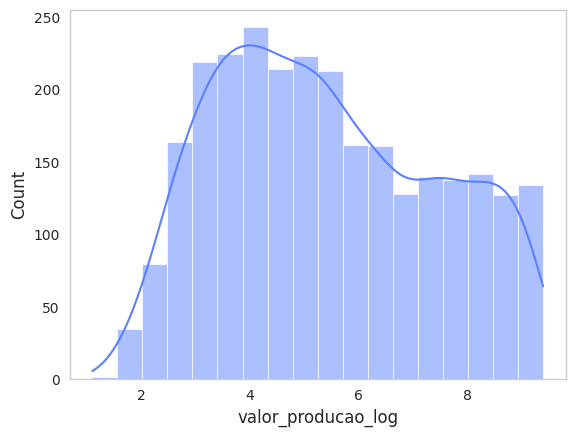

In [ ]:
sns.histplot(base_tratada['valor_producao_log'], kde=True, color='#5B80FF') # Após tratamento distribuição se aproxima um pouco mais da normal
plt.show()

**Separando a base_tratada em treino e teste**

In [ ]:
# separa a base em treino e teste
X = base_tratada.drop(columns = ['valor_producao_log'])
y = base_tratada['valor_producao_log']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state= 42,
                                                    test_size=0.3)

In [ ]:
X_train.shape, X_test.shape

((1925, 12), (825, 12))

** Variáveis quantitativas **

In [ ]:
base_tratada.columns

Index(['ano', 'area_destinada_colheita', 'area_colhida',
       'quantidade_produzida', 'rendimento_medio_producao', 'sigla_uf_AL',
       'sigla_uf_GO', 'sigla_uf_MG', 'sigla_uf_PR', 'sigla_uf_RJ',
       'sigla_uf_SE', 'sigla_uf_SP', 'valor_producao_log'],
      dtype='object')

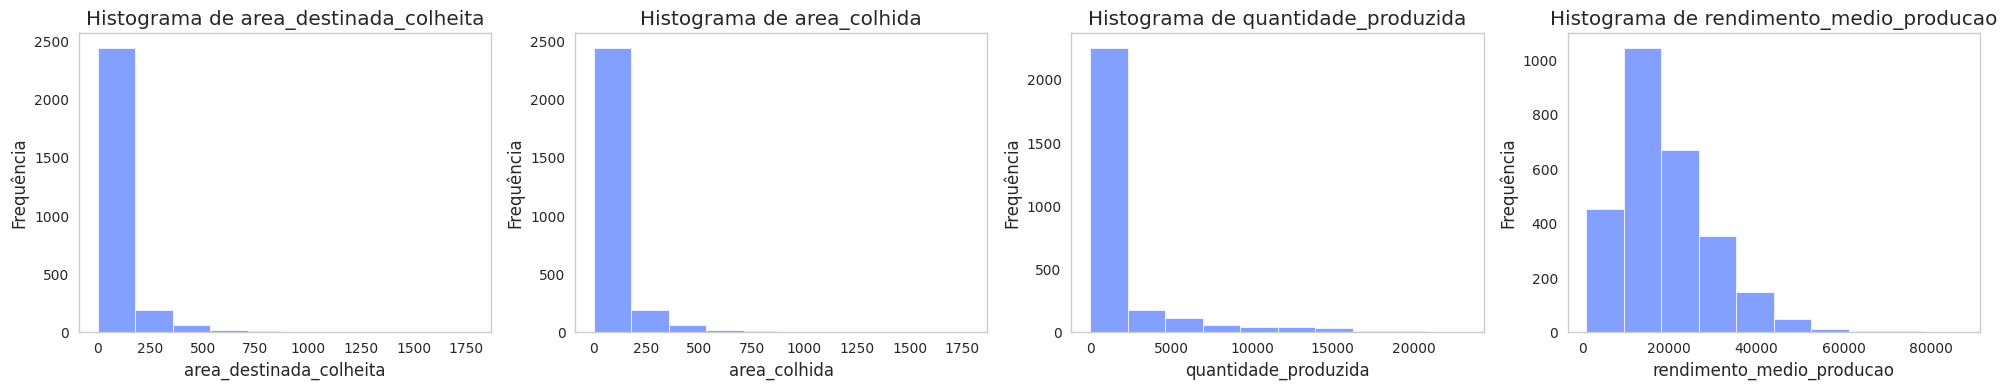

In [ ]:
# Verificando a distribuição das variáveis numéricas:

# gráficos de histograma das variáveis selecionadas
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

columns_to_plot_numeric = ['area_destinada_colheita', 'area_colhida',
       'quantidade_produzida', 'rendimento_medio_producao']

for i, column in enumerate(columns_to_plot_numeric):
    ax = axes[i % 4]
    sns.histplot(base_tratada[column], bins=10, ax=ax, color='#5B80FF')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequência')
    ax.set_title('Histograma de ' + column)

plt.tight_layout()
plt.show()

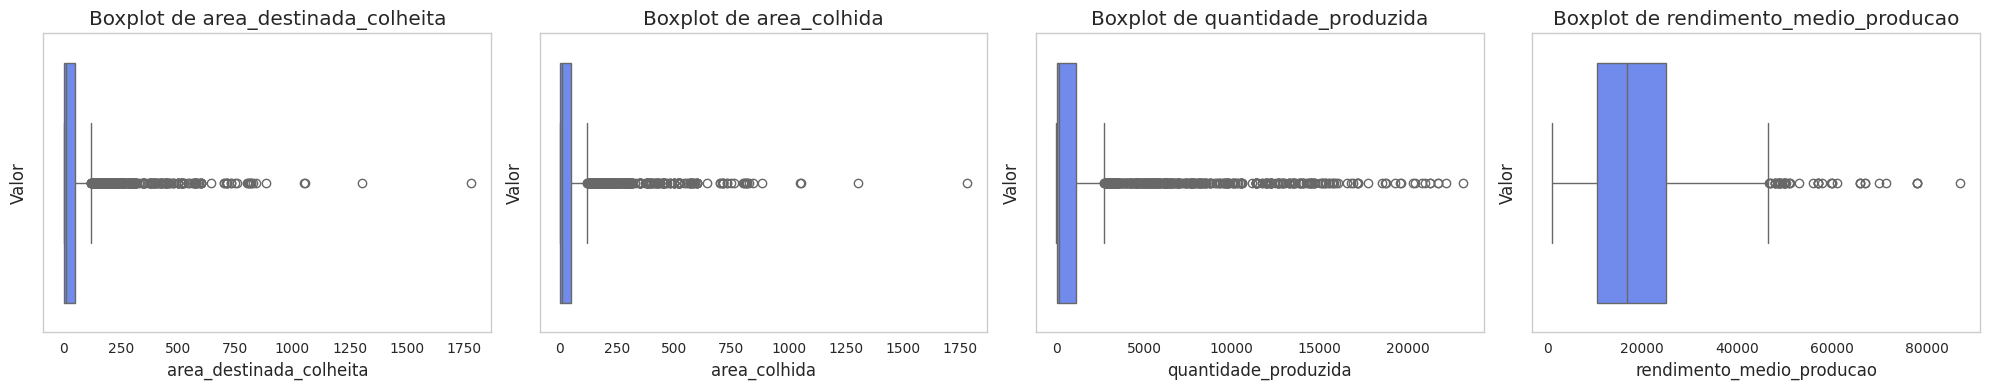

In [ ]:
# Verificando outliers:

# Boxplot das variáveis selecionadas
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

columns_to_plot_numeric = ['area_destinada_colheita', 'area_colhida',
       'quantidade_produzida', 'rendimento_medio_producao']

for i, column in enumerate(columns_to_plot_numeric):
    ax = axes[i % 4]
    sns.boxplot(x=base_tratada[column], ax=ax, color='#5B80FF')
    ax.set_xlabel(column)
    ax.set_ylabel('Valor')
    ax.set_title('Boxplot de ' + column)

plt.tight_layout()
plt.show()

É possível verificar que as **variáveis possuem uma distribuição assimétrica**, apresentando caldas a direita.

Pelo boxplot também validamos que há presença de outilers nos dados.

Dessa forma, é necessária a aplicação do método 'RobustScaler' **para dimensionar as variáveis**. O uso do RobustScaler pode ajudar a melhorar o desempenho do modelo, **garantindo que os dados sejam adequadamente escalonados e considerando a presença de valores atípicos (outilers)**.

In [ ]:
# aplicando RobustScaler nas variáveis numéricas:
columns_to_scale_numeric = ['area_destinada_colheita', 'area_colhida',
       'quantidade_produzida', 'rendimento_medio_producao']

# criar o transformador para aplicar as transformações
transformer = ColumnTransformer(
    transformers=[
        ('robust_scaler', RobustScaler(), columns_to_scale_numeric)
    ],
    remainder='passthrough'
)

# criando o pipeline com o transformador e o modelo
pipeline = Pipeline([
    ('transformer', transformer),
    ('model', LinearRegression())
])

# ajustar o pipeline aos dados de treino
pipeline.fit(X_train, y_train)

# prever os valores de saída para os dados de teste
y_pred = pipeline.predict(X_test)

# Validação da Regressão a partir de Pré-supostos

Para verificar a validação e confiabilidade da regressão realizada — ou seja, se os coeficientes são de fato representativos — é necessário que os **resíduos da regressão** apresentem as seguintes características:

* **Variância constante**: todos os resíduos devem ter a mesma variância.
* **Normalidade**: os resíduos devem ser distribuídos normalmente.

Em relação às features, preciso garantir:

* **Ausência de multicolinearidade**: as variáveis independentes não devem estar correlacionadas entre si.


In [ ]:
# calculo dos resíduos:
resid = y_test - y_pred
resid

,valor_producao_log
12883,-1.843726
2685,0.206924
14825,-0.305848
14955,0.137829
1444,-0.236121
...,...
14331,-0.137912
14182,0.371789
13714,-0.614849
14843,0.704573


In [ ]:
# comparação valores reais, previsos e seus respectivos resíduos:
comparacao = pd.DataFrame({'Valores reais (y)': y_test, 'Valores previstos (y)': y_pred, 'Resíduo': resid})
comparacao.head()

,Valores reais (y),Valores previstos (y),Resíduo
12883,3.583519,5.427245,-1.843726
2685,6.070738,5.863814,0.206924
14825,4.615121,4.920968,-0.305848
14955,4.828314,4.690484,0.137829
1444,9.050406,9.286527,-0.236121


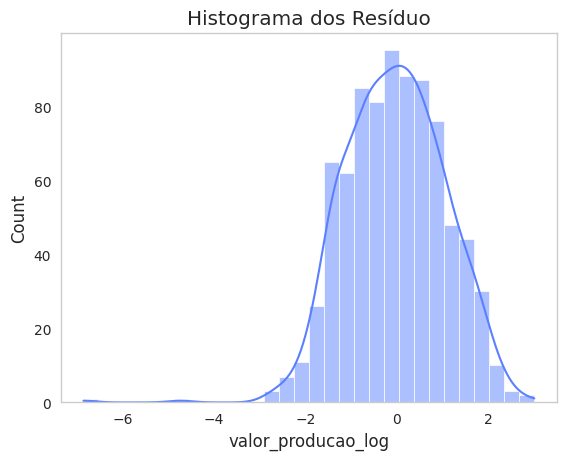

In [ ]:
# Verificar a distribuição dos residuos
sns.histplot(resid, kde=True, color='#5B80FF')
plt.title('Histograma dos Resíduo')
plt.show()

In [ ]:
# verificando a normalidade dos resíduos matemáticamente - Shapiro-Wild:
stat, p_valor = shapiro(resid)

print('Estatística de teste:', stat)
print('Valor p:', p_valor)

if p_valor > 0.05:
  print(f'Valor p é {round(p_valor,3)} e maior que 0.05, portanto os resíduos seguem uma distribuição normal')
else:
  print(f'Valor p é {round(p_valor,3)} e menor que 0.05, portanto os resíduos não seguem uma distribuição normal')

Estatística de teste: 0.9828296116480494
Valor p: 2.9380570516483467e-08
Valor p é 0.0 e menor que 0.05, portanto os resíduos não seguem uma distribuição normal


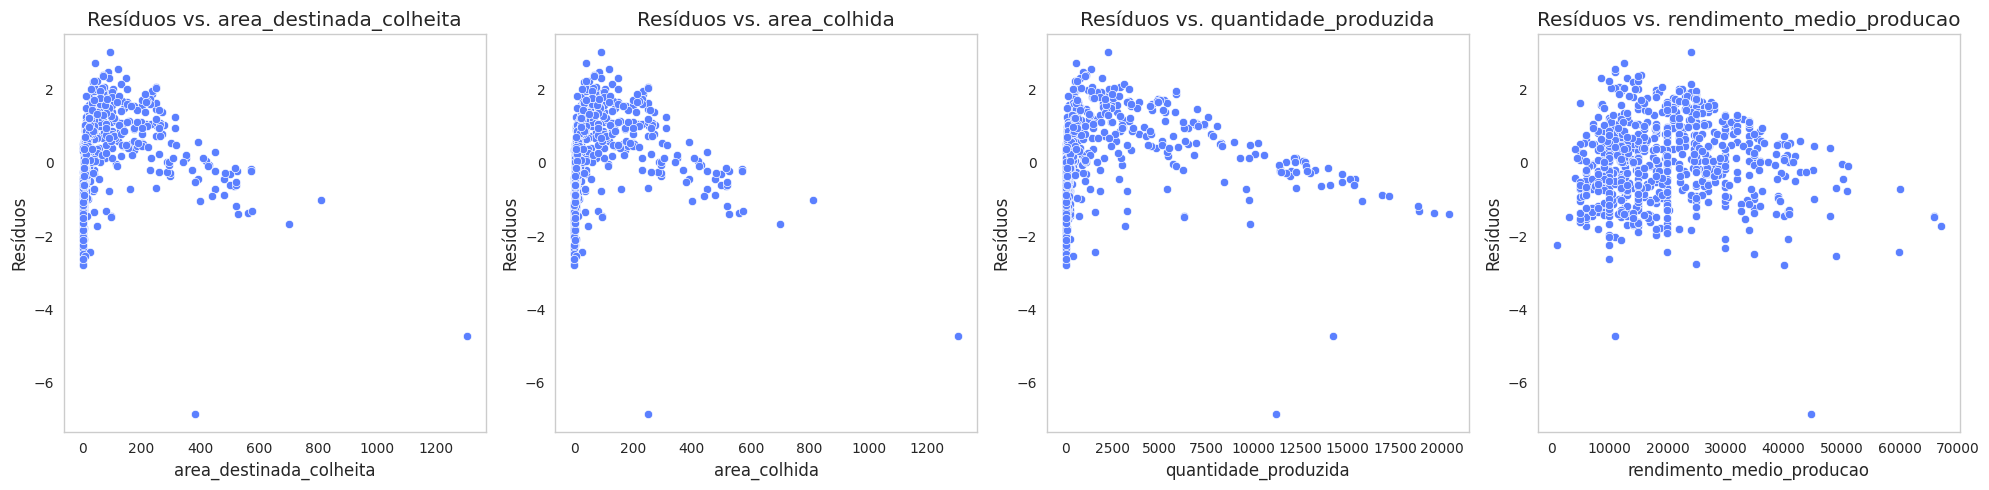

In [ ]:
# gráficos de residuo vs x's para variáveis numéricas
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

columns_to_plot = ['area_destinada_colheita', 'area_colhida',
       'quantidade_produzida', 'rendimento_medio_producao']

for i, column in enumerate(columns_to_plot):
    ax = axes[i % 4]
    sns.scatterplot(x=X_test[column], y=resid, ax=ax, color='#5B80FF')
    ax.set_xlabel(column)
    ax.set_ylabel('Resíduos')
    ax.set_title('Resíduos vs. ' + column)

plt.tight_layout()
plt.show()

In [ ]:
# Verificando a multicolinearidade das variáveis - VIF

X_train_transformed = pipeline.named_steps['transformer'].transform(X_train) #extraindo as infos de X tratadas no pipeline
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train.columns) # Convertendo para DataFrame e atribuindo os nomes das colunas originais

#calculando VIF

vif_data = pd.DataFrame()
vif_data['Variável'] = X_train_transformed.columns
vif_data['VIF'] = [variance_inflation_factor(X_train_transformed.values, i) for i in range(X_train_transformed.shape[1])]

vif_data['Conclusão'] = ['Não há multicolinearidade'
                         if v == 1 else 'Nivel moderado de multicolinearidade'
                         if 1 < v < 5 else 'Alta multicolinearidade'
                         for v in vif_data['VIF']]
vif_data

,Variável,VIF,Conclusão
0,ano,8.713281e+05,Alta multicolinearidade
1,area_destinada_colheita,8.712968e+05,Alta multicolinearidade
2,area_colhida,8.162926e+00,Alta multicolinearidade
3,quantidade_produzida,2.127115e+00,Nivel moderado de multicolinearidade
4,rendimento_medio_producao,1.009189e+00,Nivel moderado de multicolinearidade
5,sigla_uf_AL,3.819972e+05,Alta multicolinearidade
6,sigla_uf_GO,2.880959e+05,Alta multicolinearidade
7,sigla_uf_MG,2.269157e+06,Alta multicolinearidade
8,sigla_uf_PR,1.683195e+06,Alta multicolinearidade
9,sigla_uf_RJ,1.748012e+05,Alta multicolinearidade




**Conclusões sobre Features e Resíduos**

Concluo que **os resíduos não possuem uma distribuição normal, o que viola a suposição de homocedasticidade** — ou seja, a variância constante dos erros (resíduos) em todos os níveis das variáveis independentes. Quando essa suposição não é atendida, as estimativas dos coeficientes de regressão podem se tornar ineficientes e enviesadas. **Isso significa que as estimativas dos coeficientes podem não ser tão precisas e confiáveis quanto o esperado.**

Vale lembrar que, na prática, é raro que a hipótese de normalidade seja plenamente atendida. No entanto, para datasets suficientemente grandes, a Lei dos Grandes Números indica que a distribuição tende a se aproximar da normal. Assim, o fato de a hipótese de normalidade não ser cumprida **não invalida o modelo, apenas limita a validade dos resultados para amostras grandes o suficiente.**

Outro ponto a considerar é a possível presença de **endogeneidade**, ou seja, pode haver alguma variável que influencia a nossa variável target, mas que não está presente no modelo.

Por fim, identifiquei que as variáveis 'quantidade_produzida' e 'rendimento_medio_producao' são as únicas que não apresentam alta multicolinearidade (VIF < 5). Todas as outras variáveis podem influenciar os coeficientes e as métricas do modelo devido à multicolinearidade.




**Métricas para Validação dos Resultados da Regressão**

Para avaliar a eficiência do modelo, utilizo as seguintes métricas:

* **R²**: Proporção da variância da variável target explicada pelas features do modelo. O objetivo é maximizar essa métrica — quanto mais próximo de 1, melhor.
* **RMSE (Root Mean Squared Error)**: Raiz da média da diferença quadrática entre os valores reais e os valores ajustados. O objetivo é minimizar — quanto mais próximo de 0, melhor.
* **MAE (Mean Absolute Error)**: Média das diferenças absolutas entre as previsões do modelo e os valores reais. Assim como o RMSE, busca-se minimizá-lo — quanto mais próximo de 0, melhor.

In [ ]:
# define uma função para calcular o rmse
def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)

In [ ]:
# previsão com os dados de treino
y_pred_train = pipeline.predict(X_train)
# previsão com os dados de teste
y_pred_test = pipeline.predict(X_test)


In [ ]:
# calculo o RMSE
rmse_train = rmse(y_train, y_pred_train)
rmse_test = rmse(y_test, y_pred_test)

rmse_train, rmse_test

(1.1047, 1.0863)

In [ ]:
# métrica nos dados de treino e teste
r_train = pipeline.score(X_train, y_train)
r_test = pipeline.score(X_test, y_test)
# modelo.score(X_train, y_train), modelo.score(X_test, y_test)

r_train, r_test

(0.6974980140993781, 0.7084461988953414)

In [ ]:
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

mae_train, mae_test

(0.8784181733725875, 0.8733486485088058)

In [ ]:
#dataset de resultados
results_df = pd.DataFrame({'R2': [r_train, r_test], 'RMSE': [rmse_train, rmse_test], 'MAE': [mae_train, mae_test]}, index=['Treino', 'Teste'])
results_df

,R2,RMSE,MAE
Treino,0.697498,1.1047,0.878418
Teste,0.708446,1.0863,0.873349


# **Conclusões sobre o Modelo**

* **Para o R²**, observei valores de 0.697 nos dados de treino e 0.708 nos dados de teste, indicando que** o modelo é capaz de explicar cerca de 70% da variabilidade dos dados**. Esses resultados sugerem uma boa capacidade preditiva e consistência entre os conjuntos de treino e teste, apontando para uma generalização eficiente.

* **Em relação ao RMSE**, obtive valores de 1.1047 no treino e 1.0863 no teste, **o que indica que o modelo está se saindo bem em termos de previsões, com erros relativamente baixos** e um desempenho equilibrado entre os dois conjuntos de dados.

* **Para o MAE**, os valores foram de 0.878 no treino e 0.873 no teste, mostrando que, em média, as previsões do modelo estão desviando menos de uma unidade em relação aos valores reais, reforçando a precisão das estimativas.

No entanto, a análise de multicolinearidade revelou **altos valores de VIF em diversas variáveis, o que pode indicar redundância entre elas**. O tratamento dessa questão será importante para otimizar ainda mais o desempenho do modelo. Uma possível abordagem seria a aplicação de técnicas de regularização, como Ridge, para reduzir o impacto da multicolinearidade e melhorar a robustez do modelo.


# **Regularização Ridge e Validação Cruzada**

Como percebi a presença de multicolinearidade em boa parte das variáveis, decidi aplicar a **regressão Ridge** para regularizar os coeficientes. A regularização Ridge reduz os coeficientes de todas as variáveis, sem zerá-los completamente. Essa técnica é especialmente útil em casos como o meu, onde **todas as variáveis têm alguma contribuição para o modelo, mas a multicolinearidade está fazendo com que algumas variáveis se tornem instáveis**. Como as variáveis estão correlacionadas, não quero eliminar nenhuma delas.

Além disso, vou utilizar o método de validação cruzada para encontrar o valor de alpha que melhor ajuste os coeficientes.

In [ ]:
# função de validação cruzada com diferentes valores de alpha para Ridge

# função de validação cruzada com diferentes valores de alpha para Ridge
def test_regularizacao(pipeline, X_train, y_train, X_test, y_test):

    list_alpha = [0.0001, 0.001, 0.1, 1, 5, 10, 15, 20, 30, 45, 50, 60, 70, 80, 90]
    result_list = []

    for alpha_number in list_alpha:
        # Usar named_steps para acessar o modelo na pipeline
        pipeline.named_steps['model'].set_params(alpha=alpha_number)
        pipeline.fit(X_train, y_train)  # ajustar o pipeline aos dados de treinamento

        # Prever os valores de treino e teste
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)

        # Calcular R², RMSE e MAE
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)

        # Armazenar os resultados em uma lista
        result_list.append({
            'alpha': alpha_number,
            'r2_train': r2_train,
            'r2_test': r2_test,
            'RMSE_train': RMSE_train,
            'RMSE_test': RMSE_test,
            'MAE_train': mae_train,
            'MAE_test': mae_test
        })

    # Converter a lista de resultados em DataFrame
    result_df = pd.DataFrame(result_list).round(4)
    return result_df

In [ ]:
# Regressão Lasso e pipeline:

columns_to_scale_numeric = ['area_destinada_colheita', 'area_colhida',
       'quantidade_produzida', 'rendimento_medio_producao' ]

transformer = ColumnTransformer(
    transformers=[
        ('robust_scaler', RobustScaler(), columns_to_scale_numeric)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('transformer', transformer),
    ('model', Ridge())
])

resultados = test_regularizacao(pipeline, X_train, y_train, X_test, y_test)

resultados.sort_values(by='r2_test', ascending=False)

,alpha,r2_train,r2_test,RMSE_train,RMSE_test,MAE_train,MAE_test
3,1.0000,0.6975,0.7218,1.1047,1.0611,0.8789,0.8674
4,5.0000,0.6971,0.7216,1.1054,1.0615,0.8809,0.8680
2,0.1000,0.6975,0.7214,1.1047,1.0619,0.8785,0.8678
5,10.0000,0.6963,0.7207,1.1068,1.0631,0.8842,0.8717
6,15.0000,0.6954,0.7197,1.1084,1.0652,0.8875,0.8753
7,20.0000,0.6945,0.7186,1.1102,1.0673,0.8907,0.8782
8,30.0000,0.6926,0.7164,1.1136,1.0714,0.8964,0.8833
9,45.0000,0.6899,0.7133,1.1184,1.0772,0.9038,0.8899
10,50.0000,0.6891,0.7124,1.1199,1.0789,0.9060,0.8919
1,0.0010,0.6975,0.7107,1.1047,1.0821,0.8784,0.8727


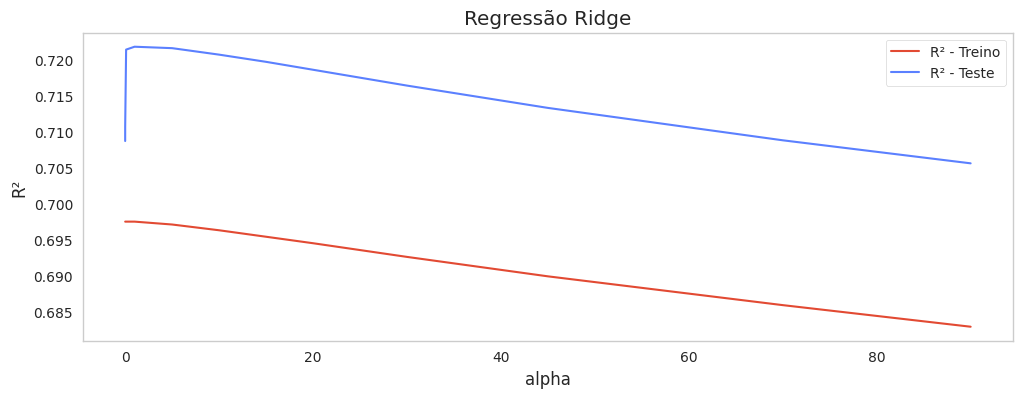

In [ ]:
#gráfico evolução R² regressão Ridge

fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(data=resultados, x='alpha', y='r2_train', ax=ax, label='R² - Treino')
sns.lineplot(data=resultados, x='alpha', y='r2_test', ax=ax, label='R² - Teste', color='#5B80FF')

ax.set_title('Regressão Ridge')
ax.set_xlabel('alpha')
ax.set_ylabel('R²')

plt.show()


# **Conclusão**

**Regressão Linear Comum:**

* R² (Treino/Teste): 0.6975 / 0.7084
* RMSE (Treino/Teste): 1.1047 / 1.0863
* MAE (Treino/Teste): 0.8784 / 0.873

O modelo de regressão linear comum apresenta um bom desempenho, em torno de 0.7 tanto para treino quanto para teste. Os erros (RMSE e MAE) são relativamente baixos e semelhantes entre os conjuntos de treino e teste, sugerindo que a regressão linear comum está ajustando bem os dados, sem sinais claros de overfitting.

Entretanto,

**Regressão Ridge: Com Alpha = 1**

* R² (Treino/Teste): 0.6975 / 0.7218
* RMSE (Treino/Teste): 1.1047 / 1.0611
* MAE (Treino/Teste): 0.8789 / 0.8674

Com **α = 1.0**, o modelo Ridge mostra uma ligeira melhora em relação à regressão linear comum no conjunto de teste, principalmente no R² (de 0.7084 para 0.7218) e no RMSE (de 1.0863 para 1.0611). Isso sugere que a regularização do Ridge está ajudando o modelo a generalizar melhor os dados de teste, com uma pequena redução nos erros. O MAE também melhora ligeiramente no teste, indicando que o modelo Ridge é um pouco mais robusto na previsão.

**Conclusão Final**

Nesse caso, **a Regressão Ridge é a melhor escolha**, pois oferece uma pequena, mas significativa melhora no modelo, sem comprometer seu desempenho, especialmente no conjunto de teste.